In [2]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
import time
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution, greedy_2_regret_weighted, score, get_random_solution
from typing import Callable, Tuple
from abc import ABC, abstractmethod
from sortedcontainers import SortedList

In [3]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [4]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [5]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected: SortedList):
        n = len(solution)
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        start = i - 1
        end = j + 2
        reversed_segment = set(range(start, end)) 
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in reversed_segment or y in reversed_segment:
                affected.add(k)

        return list(affected)

    
class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        n = len(solution)
        adjacent_indices = { (i - 1) % n, (i + 1) % n, i }
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in adjacent_indices or y in adjacent_indices:
                affected.add(k)
            if y == j:
                affected.add(k)
        
        return list(affected)

class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
        self.size = sum(n.neighborhood_size() for n in self.neighborhoods)
        self.indexes=[]
        for neighborhood in neighborhoods:
            self.indexes.extend(neighborhood.indexes)
    def neighborhood_size(self):
        return self.size
    
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
            size=self.neighborhoods[0].neighborhood_size()
            if ind < size:
                return self.neighborhoods[0].get_affected_indexes(ind, solution)
            else:
                ind-=size
                return [x+size for x in self.neighborhoods[1].get_affected_indexes(ind, solution)]
            

In [6]:
class SteepestLocalSearch:
    def __init__(self, starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: 'Neighborhood'):
        self.solution = starting_solution.copy()
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.neighborhood = neighborhood
        self.unselected = SortedList(range(len(costs)))
        for i in starting_solution:
            self.unselected.remove(i)
        self.LM = {} 

    def initialize_moves(self):
        for i in range(self.neighborhood.neighborhood_size()):
            delta = self.neighborhood.get_difference(i, self.solution, self.unselected)
            if delta < 0: 
                self.LM[i] = delta

    def update_moves(self, affected_indexes: List[int]):
 
        for i in affected_indexes:
            delta = self.neighborhood.get_difference(i, self.solution, self.unselected)
            if delta < 0:
                self.LM[i] = delta 
            elif i in self.LM:
                del self.LM[i]

    def get_sorted_moves(self):
        return sorted(self.LM.items(), key=lambda x: x[1])

    def is_move_applicable(self, move: Tuple[int, float]) -> bool:
        ind, _ = move
        i, j = self.neighborhood.indexes[ind]
        current_edges = {(self.solution[k], self.solution[(k + 1) % len(self.solution)]) for k in range(len(self.solution))}
        move_edges = {(self.solution[i - 1], self.solution[i]), (self.solution[j], self.solution[(j + 1) % len(self.solution)])}
        reversed_edges = {(b, a) for (a, b) in move_edges}

    
        if move_edges.isdisjoint(current_edges) and reversed_edges.isdisjoint(current_edges):
            return 0 
        elif move_edges.issubset(reversed_edges):
            return 2  
        return 1  

    def apply_move(self, move: Tuple[int, float]) -> List[int]:
        ind, _ = move
        affected_indexes = self.neighborhood.get_affected_indexes(ind, self.solution)
        self.solution = self.neighborhood.modify_solution(ind, self.solution, self.unselected)
        return affected_indexes

    def steepest_search(self):
        self.initialize_moves()  
        while True:
            move_found = False
            sorted_LM = self.get_sorted_moves()  

            for move in sorted_LM:
                app = self.is_move_applicable(move)
                if app == 1:
                    affected_indexes = self.apply_move(move) 
                    del self.LM[move[0]]  
                    self.update_moves(affected_indexes) 
                    move_found = True
                    break
                elif app == 2:
                    continue
                else:
                    del self.LM[move[0]]  

            if not move_found:
                return self.solution  



In [ ]:
def msls(number_of_iterations, distance_matrix, costs, neighborhood):
    solutions=[get_random_solution(200) for x in range(number_of_iterations)]
    best_fit=999999999
    best_sol=None
    for sol in solutions:
        st=SteepestLocalSearch(sol, dist, costs, neighborhood)
        s=st.steepest_search()
        if score(s, distance_matrix, costs) < best_fit:
            best_fit=score(s, distance_matrix, costs)
            best_sol=s
    return best_sol

In [47]:
def ils(pert_f, distance_matrix, costs, neighborhood):
    sol=get_random_solution(200)
    best_fit=999999999
    best_sol=None
    start_time=time.time()
    i=0
    while time.time()-start_time<200:
        for function in pert_f:
            sol=function(sol)
        st=SteepestLocalSearch(sol, dist, costs, neighborhood)
        sol=st.steepest_search()
        scor=score(sol, distance_matrix, costs)
        i+=1
        if  scor< best_fit:
            best_fit=scor
            best_sol=sol
    return best_sol, i

In [27]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])


In [ ]:
s=msls(200, dist, costs, neighborhood)

In [48]:
s,i=ils([rswap], dist, costs, neighborhood)

IndexError: list index out of range

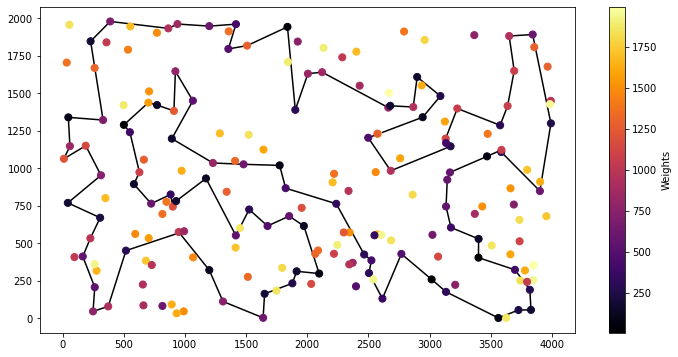

In [41]:
plot_solution(s, coordinates, costs, '')

In [42]:
score(s, dist, costs)

75786

In [56]:
def per(sol):
    un=[x for x in range(200) if x not in sol]
    sol=sol[:95]+un[:5]
    return sol

In [49]:
def rswap(sol):
    i=np.random.randint(0,100)
    j=np.random.randint(0,100)
    tmp=sol[i]
    sol[i]=sol[j]
    sol[j]=tmp
    return sol

In [69]:
def shuff(sol):
    i=np.random.randint(0,100)
    j=np.random.randint(0,100)
    s=sol[i:j]
    np.random.shuffle(s)
    sol[i:j]=s
    return sol

In [52]:
def invert(sol):
    i=np.random.randint(0,100)
    j=np.random.randint(0,100)
    sol[i:j]=sol[i:j][::-1]
    return sol

In [53]:
s,i=ils([rswap], dist, costs, neighborhood)

In [54]:
score(s, dist, costs)

71626

In [55]:
s,i=ils([shuff], dist, costs, neighborhood)

TypeError: can only assign an iterable

In [ ]:
score(s, dist, costs)

In [ ]:
s,i=ils([invert], dist, costs, neighborhood)

In [ ]:
score(s, dist, costs)

In [ ]:
s,i=ils([rswap, per], dist, costs, neighborhood)

In [ ]:
score(s, dist, costs)

In [ ]:
s,i=ils([per, shuff], dist, costs, neighborhood)

In [ ]:
score(s, dist, costs)